# BSIF Algorithm for replay attack

In [1]:
import numpy as np
import cv2
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from skimage import feature
from scipy.signal import convolve

# Filter data

In [2]:
def read_matrix_from_file(file_path):
    # extract matrix size from file path
    size_str = file_path.split('/')[-1].split('_')[1]
    size = [int(x) for x in size_str.split('x')]
    temp = file_path.split('/')[-1].split('_')[2]
    size.append(int(temp.split('bit')[0]))
    # print(int(temp.split('bit')[0]) + 2)

    # print(size)

    # create matrix of that size by reading file
    with open(file_path, 'r') as f:
        matrix = np.zeros(size)
        for i, line in enumerate(f):
            row = [float(x) for x in line.split(',')]
            matrix[i//size[1], i%size[1], :] = row
    return matrix

In [3]:
m13x13_12 = read_matrix_from_file('filters_txt/finetuned_bsif_eyetracker_data/ICAtextureFilters_13x13_12bit.txt')
m17x17_12 = read_matrix_from_file('filters_txt/finetuned_bsif_eyetracker_data/ICAtextureFilters_17x17_12bit.txt')
m21x21_9 = read_matrix_from_file('filters_txt/finetuned_bsif_eyetracker_data/ICAtextureFilters_21x21_9bit.txt')

In [4]:
seed = 1307
np.random.seed(seed)
def get_normalized_distribution(n):
    loc = 127.5
    scale = 63.75
    x = np.linspace(0, 255, n)
    y = np.exp(-(x - loc)**2 / (2 * scale**2)) / (scale * np.sqrt(2 * np.pi))
    return y / np.sum(y) * 255

In [5]:
def convolve_image(image, patch, t = 0.8):
    t = t*255
    # add padding to the image
    pad_size1 = int((patch.shape[0] - 1) / 2)
    pad_size2 = int((patch.shape[1] - 1) / 2)
    # print(image.shape)
    
    # perform convolution on the padded image with the patch
    result = np.zeros((image.shape[0], image.shape[1], patch.shape[2]), dtype=np.float64)
    n = patch.shape[2]
    c = get_normalized_distribution(n)
    for i in range(n):
        result1 = convolve(image, patch[:,:,i])
        # t = 0.8
        # c = 255*0.07*(i+1)
        binary_mask = np.zeros(result1.shape, dtype=np.float64)
        binary_mask[result1 > t] = c[i]

        # result[:,:,i] = binary_mask[pad_size1//2:-pad_size1//2, pad_size2//2:-pad_size2//2]
        result[:,:,i] = binary_mask[pad_size1:-pad_size1, pad_size2:-pad_size2]
        # print("original image shape: ", image.shape)
        # print("result shape: ", result.shape)
        # print("binary_mask shape: ", binary_mask.shape)
        # print("Pad1 size" , pad_size1)
        # print("Pad2 size" , pad_size2)
    
    return (result.sum(axis=2)*255)%256

In [6]:
def convolve_rgb_image(image, patch, t = 0.8):
    # print("image shape: ", image.shape)
    r_image = np.array(convolve_image(image[:, :, 0], patch, t))/255
    g_image = np.array(convolve_image(image[:, :, 1], patch, t))/255
    b_image = np.array(convolve_image(image[:, :, 2], patch, t))/255
    # return r_image
    
    return np.stack([r_image, g_image, b_image], axis = 2)

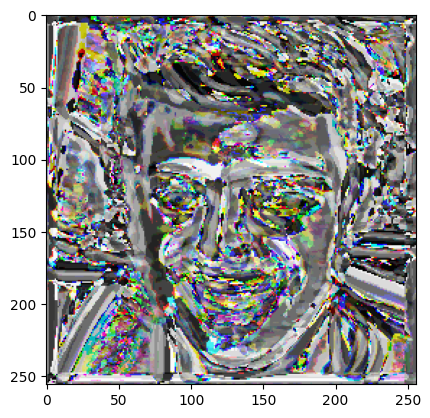

In [8]:
image_path1 = 'Big_Data/Actual_Pictures/img040634.png'
conv_img1 = convolve_rgb_image(cv2.imread(image_path1), m17x17_12, 0.01)
# print(conv_img1[75][150])
plt.imshow(conv_img1)

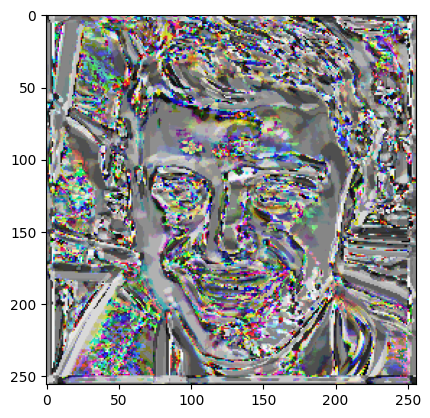

In [9]:
image_path1 = 'Big_Data/Actual_Pictures/img040634.png'
conv_img1 = convolve_rgb_image(cv2.imread(image_path1), m13x13_12, 0.01)
# print(conv_img1[75][150])
# print(np.where(conv_img1 > 1)[0])
plt.imshow(conv_img1)

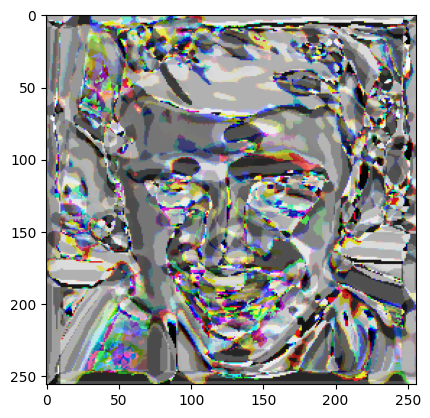

In [10]:
image_path1 = 'Big_Data/Actual_Pictures/img040634.png'
conv_img1 = convolve_rgb_image(cv2.imread(image_path1), m21x21_9, 0.01)
# print(conv_img1[75][150])
plt.imshow(conv_img1)
# print(conv_img1.shape)

In [11]:
# https://github.com/aczajka/iris-recognition---pm-diseased-human-driven-bsif/tree/main
# https://github.com/mitre/biqt-contact-detector/blob/94df7132a412ffa02a41c4dce6d04b63e632e7c4/src/python/inference/cv_features/features/extract_features.py#L44
# https://github.com/akuehlka/emvlc-ipad/blob/01a3a0fdaea0f292cafd459fabbe30a91b0553d4/antispoofing/mcnns/features/descriptors.py

In [8]:
def calc_hist(img):
    histogram = [0] * 3
    for j in range(3):
        histr = cv2.calcHist([img], [j], None, [256], [0, 256])
        histr *= 255.0 / histr.max()
        histogram[j] = histr
    return np.array(histogram).T[0]

In [9]:
def get_hist(image_path, patch, t = 0.8):
    # read the image
    img = cv2.imread(image_path)

    # convert the image to YCrCb color space
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # convert the image to LUV color space
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    # print(luv)

    # print("\n\nBSIF:")
    bsif_img = np.round(convolve_rgb_image(img, patch, t)*255)
    bsif_img = np.asarray(bsif_img, dtype=np.uint8)
    # print(bsif_img)

    # calculate the histograms
    ycrcb_hist = calc_hist(ycrcb)
    luv_hist = calc_hist(luv)
    bsif_hist = calc_hist(bsif_img)
    # print(luv_hist.shape)
    # print("\n\nBSIF:")
    # print(bsif_hist.shape)

    return np.append(bsif_hist.ravel(), np.append(ycrcb_hist.ravel(), luv_hist.ravel()))

In [10]:
def read_pictures(folder_path1, folder_path2, patch):
    hist_list = []
    
    file_list = os.listdir(folder_path1)
    # loop through each file and get its histogram
    for file_name in file_list:
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path1, file_name)
            hist = get_hist(file_path, patch)
            hist_list.append([hist, 1])
        # break
    
    file_list = os.listdir(folder_path2)
    # loop through each file and get its histogram
    for file_name in file_list:
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path2, file_name)
            hist = get_hist(file_path, patch)
            hist_list.append([hist, -1])
        # break

    # store the histograms in a pandas dataframe
    df = pd.DataFrame(hist_list, columns=['hist', 'label'])
    
    return df

In [11]:
def df_to_csv(df, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists. Exiting without writing.")
        return
    # create a new dataframe with 1536 columns
    new_df = pd.DataFrame(df.iloc[:, 0].tolist(), columns=[f'feature{i}' for i in range(1, 2305)])
    
    # add the label column to the new dataframe
    new_df['label'] = df.iloc[:, 1]
    
    # write the new dataframe to a csv file
    new_df.to_csv(filename, index=False)
    
    print(f"{filename} saved successfully.")

In [22]:
small_bsif_df_17 = read_pictures('Small_Data/Actual_Pictures', 'Small_Data/Replay_Attack', m17x17_12)
print(small_bsif_df_17.head())
df_to_csv(small_bsif_df_17, 'small_bsif_17.csv')

                                                hist  label
0  [254.99998, 255.0, 254.99998, 0.0, 0.0, 0.0, 0...      1
1  [255.00002, 254.99998, 255.0, 0.0, 0.005086267...      1
2  [255.00002, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
3  [255.0, 255.0, 254.99998, 0.0, 0.0, 0.0, 0.0, ...      1
4  [254.99998, 254.99998, 254.99998, 0.0, 0.0, 0....      1
small_bsif_17.csv saved successfully.


In [23]:
small_bsif_df_13 = read_pictures('Small_Data/Actual_Pictures', 'Small_Data/Replay_Attack', m13x13_12)
print(small_bsif_df_13.head())
df_to_csv(small_bsif_df_13, 'small_bsif_13.csv')

                                                hist  label
0  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
1  [254.99998, 255.00002, 255.00002, 0.0, 0.0, 0....      1
2  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
3  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
4  [254.99998, 254.99998, 254.99998, 0.0, 0.0, 0....      1
small_bsif_13.csv saved successfully.


In [24]:
small_bsif_df_21 = read_pictures('Small_Data/Actual_Pictures', 'Small_Data/Replay_Attack', m21x21_9)
print(small_bsif_df_21.head())
df_to_csv(small_bsif_df_21, 'small_bsif_21.csv')

                                                hist  label
0  [255.0, 255.00002, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
1  [255.0, 255.00002, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
2  [255.0, 255.0, 255.00002, 0.0, 0.0, 0.0, 0.0, ...      1
3  [255.0, 255.00002, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
4  [255.00002, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
small_bsif_21.csv saved successfully.


In [19]:
big_bsif_df_17 = read_pictures('Big_Data/Actual_Pictures', 'Big_Data/Replay_Attack', m17x17_12)
print(big_bsif_df_17.head())
df_to_csv(big_bsif_df_17, 'big_bsif_17.csv')

                                                hist  label
0  [254.99998, 255.0, 255.0, 0.0, 0.0058841174, 0...      1
1  [255.0, 255.00002, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
2  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
3  [254.99998, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
4  [254.99998, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
big_bsif_17.csv saved successfully.


In [12]:
big_bsif_df_21 = read_pictures('Big_Data/Actual_Pictures', 'Big_Data/Replay_Attack', m21x21_9)
print(big_bsif_df_21.head())
df_to_csv(big_bsif_df_21, 'big_bsif_21.csv')

                                                hist  label
0  [255.00002, 255.0, 255.0, 0.0, 0.0, 0.04346788...      1
1  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
2  [254.99998, 255.00002, 255.0, 0.069615066, 0.3...      1
3  [255.0, 255.0, 255.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
4  [255.0, 255.0, 255.0, 0.0, 0.036668487, 0.2741...      1
big_bsif_21.csv saved successfully.


In [21]:
big_bsif_df_13 = read_pictures('Big_Data/Actual_Pictures', 'Big_Data/Replay_Attack', m13x13_12)
print(big_bsif_df_13.head())
df_to_csv(big_bsif_df_13, 'big_bsif_13.csv')

                                                hist  label
0  [254.99998, 255.0, 255.00002, 0.0045678457, 0....      1
1  [255.00002, 254.99998, 255.00002, 0.0, 0.0, 0....      1
2  [255.00002, 254.99998, 255.0, 0.0, 0.0, 0.0, 0...      1
3  [255.0, 255.0, 254.99998, 0.0, 0.0, 0.0, 0.0, ...      1
4  [255.0, 255.00002, 255.0, 0.0, 0.0, 0.0, 0.0, ...      1
big_bsif_13.csv saved successfully.


In [13]:
from sklearn.model_selection import train_test_split
def shuffle_and_split_csv(input_file, train_file, test_file, test_size=0.2):
    # read the csv file
    df = pd.read_csv(input_file)

    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)

    # split the dataframe into training and testing sets
    train, test = train_test_split(df, test_size=test_size, random_state=42)

    # write the training and testing sets to csv files
    train.to_csv(train_file, index=False)
    test.to_csv(test_file, index=False)

    print("Data shuffled and split into training.csv and testing.csv")

In [14]:
shuffle_and_split_csv('big_bsif_13.csv', 'big_bsif_13_training.csv', 'big_bsif_13_testing.csv', 0.3)
shuffle_and_split_csv('big_bsif_17.csv', 'big_bsif_17_training.csv', 'big_bsif_17_testing.csv', 0.3)
shuffle_and_split_csv('big_bsif_21.csv', 'big_bsif_21_training.csv', 'big_bsif_21_testing.csv', 0.3)

Data shuffled and split into training.csv and testing.csv
Data shuffled and split into training.csv and testing.csv
Data shuffled and split into training.csv and testing.csv


In [15]:
shuffle_and_split_csv('small_bsif_13.csv', 'small_bsif_13_training.csv', 'small_bsif_13_testing.csv', 0.3)
shuffle_and_split_csv('small_bsif_17.csv', 'small_bsif_17_training.csv', 'small_bsif_17_testing.csv', 0.3)
shuffle_and_split_csv('small_bsif_21.csv', 'small_bsif_21_training.csv', 'small_bsif_21_testing.csv', 0.3)

Data shuffled and split into training.csv and testing.csv
Data shuffled and split into training.csv and testing.csv
Data shuffled and split into training.csv and testing.csv
